In [1]:
from IPython.display import HTML

main_text = """
<video id="video" width="320" height="240" autoplay></video>
<button id="snap">Snap Photo</button>
<canvas id="canvas" width="320" height="240"></canvas>

<script>
// Grab elements, create settings, etc.
var video = document.getElementById('video');

// Get access to the camera!
if(navigator.mediaDevices && navigator.mediaDevices.getUserMedia) {
    // Not adding `{ audio: true }` since we only want video now
    navigator.mediaDevices.getUserMedia({ video: true }).then(function(stream) {
        //video.src = window.URL.createObjectURL(stream);
        //video.play();
        video.srcObject=stream;
        video.play();
    });
}

// Elements for taking the snapshot
var canvas = document.getElementById('canvas');
var context = canvas.getContext('2d');
var video = document.getElementById('video');

// Trigger photo take
document.getElementById("snap").addEventListener("click", function() {
	context.drawImage(video, 0, 0, 320, 240);
    var myCanvas = document.getElementById('canvas');
    var image = myCanvas.toDataURL("image/png");
    IPython.notebook.kernel.execute("print('testing')");
    IPython.notebook.kernel.execute("image = '" + image + "'")
});
</script>

"""
HTML(main_text)

In [66]:
import torch
img_tensors = webcam_to_tensor()

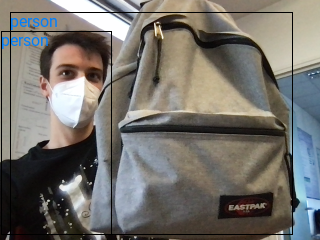

In [67]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    pretrained=True,
    box_score_thresh=0.7
)
model.eval()
predictions = model(img_tensors)

# Display image along with model prediction
display_image_and_boxes(img_tensors[0], predictions[0], category_names=COCO_CATEGORY_NAMES)

In [56]:
model.device()

AttributeError: 'FasterRCNN' object has no attribute 'device'

In [59]:
'''Test our pretrained object detector on an example image'''
import os
from urllib.request import urlopen
from PIL import Image, ImageDraw, ImageFont
import numpy as np

import torchvision

# Order of COCO category names as defined in torchvision
COCO_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def display_image_and_boxes(image, target=None, category_names=None):
    ''' 
    image: tensor
    target: dict
    category_names: list mapping class label (int) to class name (str)
    
    '''

    # Convert tensor to image and draw it.
    np_img = (image.permute(1,2,0).cpu().numpy() * 255).astype('uint8')
    im = Image.fromarray(np_img)
    draw = ImageDraw.Draw(im)

    if target:
        # Make sure the required font is available
        if not os.path.isfile('Roboto-Regular.ttf'):
            !wget https://github.com/jerpint/ivado-mila-dl-school-2019-vancouver/raw/dlschool21/assests/Roboto-Regular.ttf
        font = ImageFont.truetype(font='Roboto-Regular.ttf', size=16)

        # Draw each bounding box in the target
        for box, label in zip(target['boxes'], target['labels']):
            box = box.detach().cpu().numpy()
            draw.rectangle(box, outline='black')
            label_str =  category_names[label.cpu().numpy()] if category_names else str(label.cpu().numpy()+2)
            draw.text((box[0], box[1]), label_str, fill=(0,128,256,256), font=font)
    return im


def display_masks(image, predictions, category_names=None):
    ''' 
    image: tensor
    predictions: dict
    category_names: list mapping class label (int) to class name (str)
    
    '''
    font = ImageFont.truetype(font='Roboto-Regular.ttf', size=16)
    mask_arr = np.zeros((256, 300))
    im = Image.fromarray(mask_arr)
    draw = ImageDraw.Draw(im)
    for box, label, mask in zip(predictions['boxes'], predictions['labels'], predictions['masks']):
        mask = mask.detach().cpu().numpy().squeeze()
        mask_arr += mask
        box = box.detach().cpu().numpy()
        draw.rectangle(box, outline='black')
        label_str =  category_names[label.cpu().numpy()] if category_names else str(label.cpu().numpy()+2)
        draw.text(((box[0] + box[2])/2, (box[1]+box[3])/2), label_str, fill=1, font=font)
    mask_arr = (mask_arr > 0.5) * 255
    im_with_mask = Image.fromarray( (np.array(im) + mask_arr).astype('uint8') )
    return im_with_mask


def webcam_to_tensor():
    '''
    Convert an image URL to a pytorch tensor.

    Reorders the image axes so that channel is the first dimension and normalizes 
    channels to be in range [0,1].

    input
    -----
    URL (str): URL of the image to be processed

    returns
    -------
    img_tensor (list): list containing the image as a torch.tensor()
    '''
    
    img = Image.open(io.BytesIO(base64.b64decode(image.split(',')[1])))
    img_tensor = torch.as_tensor(np.array(img) / 255) # Normalize input to [0, 1]
    img_tensor = img_tensor.permute(2, 0, 1).float() # Reorder image axes to channel first
    img_tensor = img_tensor[0:3]
    return [img_tensor]

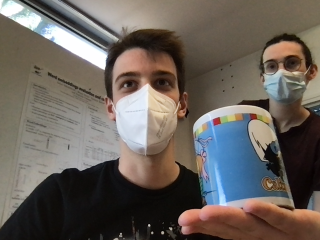

In [49]:
from PIL import Image
import base64
import io

pil_im = Image.open(io.BytesIO(base64.b64decode(image.split(',')[1])))
pil_im